This time, we consider a junction formed by a quantum dot connected to two superconduction leads. Before turning to the numerical resolution, let's define the problem. 

The leads are BCS superconductors \cite{Tinkham2004} with uniform order parameter $\Delta_l$. The operators $\psi_{\alpha,l,s}^\dagger$ create an electron of spin $s$ in the mode $\alpha$ of the lead $l$, and $d_s^\dagger$ create an electron of spin $s$ on the dot at energy $\varepsilon$. The number operators are defined as $n_{\alpha,l,s} =\psi_{\alpha,l,s}^\dagger \psi_{\alpha,l,s}$ and $n_s = d_s^\dagger d_s$. $\epsilon_{\alpha,l}$ is the energy of an electron in the state $\alpha$ of the lead $l$ at $\Delta_l = 0$. $t_{\alpha,l}$ is the tunnel coupling between the dot and the mode $\alpha$ of the lead $l$. The Fermi level of lead $l$ is denoted by $\mu_l$. $U_C$ is the strength of the coulomb interaction between the electrons of the dot. It is related to the dot capacitance $C$ by $U_C \sim e^2/2C$ \cite{Yeyati1997}.  Up to a unitary transformation, the tunnel couplings can absorb the order parameter phases such that $\Delta_l$ are positive real numbers. Hence, we may write the usual Hamiltonian \cite{Jacquet2020,Yeyati1997}. The system Hamiltonian is:
\begin{equation}
	H = H_{L} + H_{D} + H_{T}  - \sum_l \mu_l N_l,
\end{equation}
The terms $H_{L}$ is the leads Hamiltonian. $H_T$ is the tunnel coupling between the leads and the dot and $H_{D}$ describe the isolated dot.
Using the second quantization formalism, we write them as
\begin{align}
	H_{L} &= \sum_{\alpha,l,s} \epsilon_{\alpha,l} n_{\alpha,l,s} + \sum_{\alpha,l}  (\Delta_l\psi_{\alpha,l,\downarrow}^\dagger \psi_{\alpha,l,\uparrow}^\dagger + \Delta_l \psi_{\alpha,l,\uparrow} \psi_{\alpha,l,\downarrow} ), \\
	H_{D} &=  \varepsilon \sum_s d_s^\dagger d_s + U_C n_\uparrow n_\downarrow, \\
	H_T &= \sum_{\alpha,l,s} \left\{t_{\alpha,l} \psi_{\alpha,l,s}^\dagger d_s+ \text{h.c.} \right\},
	\\ N_l &= \sum_{\alpha,s} n_{\alpha,l,s}.
\end{align}  
When the Coulomb interaction is large enough, \textit{id est} $U \gg \Delta_l \gg |t_l|^2$, and the dot is in the magnetic regime $-U_C < \varepsilon < 0$ one can account for the interactions by renormalizing the junction parameters \cite{Yeyati1997, Yeyati2003, Zazunov2018}. It can be understood as follows, in presence of Coulomb interaction and when the dots have a non-zero spin, a screening electronic cloud may form. When the Coulomb interaction is large compared to the other relevant energies scales, the state of this electronic cloud is frozen. It results in a system that behaves as a non-interacting one with renormalized parameters. This situation is similar to the Fermi liquid theory. Hereafter, we will either suppose that the Coulomb interaction is negligible or that the parameters have been renormalized to include its effects. In both case, we drop the interaction term $U_C \rightarrow 0$.


A second unitary transformation removes the energy offsets from the leads to include them in the tunnelling terms \cite{Rogovin1974}. The operator of this transformation is
\begin{equation}
	U(t)  = \exp \left(i \sum_l \frac{\hat{N}_l}{\hbar} \int^t{\mu_l(\tau)} d\tau  \right).
\end{equation}
A time-dependent unitary transformation turns a Hamiltonian $H$ into $\tilde{H}$ as follows
\begin{equation}
	\tilde{H} = U(t) H U(t)^\dagger - i\hbar\frac{dU(t)}{dt} U^\dagger(t).
\end{equation}
Both the lead and the dot Hamiltonians are invariant under the action of $U(t)$ as they conserve the particle numbers. This is trivial for the dot, but the situation of the leads deserves an explanation. At first sight the term $\Delta_l \psi_{\alpha,l,\downarrow}^\dagger \psi_{\alpha,l,\uparrow}^\dagger$ and $\Delta_l \psi_{\alpha,l,\uparrow} \psi_{\alpha,l,\downarrow}$ break the particle conservation symmetry. Yet, the parameter $\Delta_l$ must satisfy the self-consistency relation \cref{eq:bcs:meanfield}. At the end, only the tunnel Hamiltonian must be examined closely. The operators $\hat{n}_{\alpha,l,s}$ commute which each others, thereby
\begin{equation}
	U(t)  = \prod_{\alpha,l,s}U_{\alpha,l,s}(t),
\end{equation}
with
\begin{equation}
	U_{\alpha,l,s} = \exp \left(i \sum_l \frac{\hat{n}_{\alpha, l,  s}}{\hbar} \int^t{\mu_l(\tau)} d\tau  \right).
\end{equation}
$U_{\alpha,l,s}$ is a unitary operator that commutes with $\psi_{\alpha',l',s'}^\dagger$ when $\left(\alpha,\,l,\, s \right) \neq \left( \alpha',\, l',\, \sigma' \right)$. Therefore
\begin{equation}
U(t) \psi_{\alpha,l,s}^\dagger U^\dagger(t) = U_{\alpha,l,s}(t) \psi_{\alpha,l,s}^\dagger U_{\alpha,l,s}^\dagger(t).
\end{equation} 
Finally, we end up with
\begin{equation}
	U(t) \psi_{\alpha,l,s}^\dagger U^\dagger(t)  =  \psi_{\alpha,l,s} \exp \left(\frac{i}{\hbar} \int^t{\mu_l(\tau)} d\tau  \right),
\end{equation}
which leads to 
\begin{equation}
	H_T = \sum_{\alpha,l,s} \left\{ t_{\alpha,l}e^{i\phi_l(t)/2} \psi_{\alpha,l,s}^\dagger d_s + \text{h.c.}\right\},
\end{equation}
with the time dependent phase $\phi_l(t)$ set by the following relation
\begin{equation}
	\phi_l(t) = \left(\frac{2e}{\hbar} \int^t{V_l(\tau)} d\tau  \right) \quad \text{with } V_l(\tau) = \mu_l(\tau)/e .
\end{equation}
The term $-\sum_l \mu_l \hat{N}_l$ being exactly cancelled by  $i\hbar\frac{dU(t)}{dt} U^\dagger(t) $, we are left with  
\begin{equation}
	H(t) = H_L + H_D + H_T(t).
\end{equation} 

To efficiently deal with the superconducting leads, we introduce the operators $d$ and $\Psi$ in a Nambu space
\begin{align}
	d &\equiv
	\begin{pmatrix}
		d_\uparrow \\ d_\downarrow^\dagger
	\end{pmatrix},
	\\
	\Psi_{\alpha,l} &\equiv
	\begin{pmatrix}
		\psi_{\alpha,l,\uparrow} \\ \psi_{\alpha,l,\downarrow}^\dagger
	\end{pmatrix}.
\end{align}
We express the Hamiltonian $H = H_L + H_D + H_T$ in this representations
\begin{align}
	H_L
	&= \sum_{\alpha,l} \Psi_{\alpha,l}^\dagger \left(\sigma_x \Delta_l + \sigma_z \epsilon_{\alpha,l}\right) \Psi_{\alpha,l},
	\\
	H_D &= d^\dagger \sigma_z \varepsilon d,
	\\
	H_T &= \sum_{\alpha,l} \left\{ \Psi_{\alpha,l}^\dagger \mathcal{T}_{\alpha,l} d + \text{h.c} \right\},
\end{align}

We are interested by the system statistical properties in the out-of-equilibrium regime, hence we aim to evaluate the system Green function $G$. It is solution of the Dyson equation. 
\begin{equation}
    G(t,t') = g(t,t') + \iint g(t,t_1) \Sigma(t_1,t_2) G(t_2,t') \text{d}t_1 \text{d}t_2,
\end{equation}
where the tiemes indices lay on the Keldysh contour. Here, $\Sigma$ is the lead induced self-energy,  and $g$ is the dot bare Green function. The numerical work will be performed using the symmetric real-time representation. Thus, we solve the following set of equation: 
\begin{align}
	G^R &= g^R + g^R\Sigma^R G^R, \\
	G^A &= {G^R}^\dagger, \\
	G^K &= \left(\mathbb{1}+G^R\Sigma^R\right)g^K\left(\mathbb{1} + \Sigma^A G^A\right) + G^R \Sigma^K G^A, 
\end{align}
$\Sigma^R,G^R$ are the retarded component, $\Sigma^A,G^A$ are  the advanced one and $\Sigma^K,G^K$ are the Kinetic or Keldysh one.
The retarded and advanced components are conjugate transposes of each other and describe the propagation of the excitations.
\begin{equation}
	K^A = \left(K^R\right)^\dagger.
\end{equation}
As their names suggest, they are retarded and advanced: 
\begin{align}
	K^R(t,t') &= \Theta(t-t') K^R(t,t') \\
	K^A(t,t') &= \Theta(t'-t) K^A(t,t'), 
\end{align}
with $\Theta$ the Heaviside function. 

## Bare Green function
Using the Nambu spinor to capture the spin degree of freedom, the bare dot retarded Green function is : 
\begin{equation}
    g^R(t) = -i e^{-i\sigma_z \varepsilon  t / \hbar }, 
\end{equation}
where $\sigma_z$ is the third Pauli matrix acting on the Nambu space. 

## Self energies 
We consider BCS like superconductors in the mean-field approximaiton. They are governed by the *Bogoliubov-de Gennes* Hamiltonian 
\begin{equation}

\end{equation}

In [69]:
using Revise
using NonEquilibriumGreenFunction
using HssMatrices
using LinearAlgebra
using CairoMakie
using LaTeXStrings
using BenchmarkTools
using DSP
#HSS compression does not leverage efficiently the BLAS multithreading. 
#It is better to turn it off
BLAS.set_num_threads(1)

In [149]:
module Junction
using Revise
using Symbolics
using NonEquilibriumGreenFunction
using LinearAlgebra
using StaticArrays
using SpecialFunctions
struct Parameters
    δt::Float64 #timestep
    T::Float64  #simulation length
    Γl::Float64 #left tunneling rate
    Γr::Float64 #right tunneling rate
    β::Float64  #inverse temperature
    Δ::Float64
    ϕl # left phase
    ϕr # right phase
    η
end
default_compression() = HssCompression(leafsize = 32)
function Parameters(; δt, T, Γl=1, Γr=1, β=1000, Δ=1.0, ϕl, ϕr, η = 0.1)
    return Parameters(δt, T, Γl, Γr, β, Δ, ϕl, ϕr, η)
end
axis(p::Parameters) = 0:p.δt:p.T

σ0() = @SMatrix [1.0 0.0; 0.0 1.0]
σx() = @SMatrix [0 1.0; 1.0 0.0]
σz() = @SMatrix [1.0 0.0; 0.0 -1.0]

function compute_retarded_lead_green_function(p::Parameters; cpr=default_compression())
    # We evaluate the lead green function at the edge
    # we take the density of normal states to be equal to 1, 
    # and include the deviation from 1 in the definition of the tunneling coupling. 
    # The superconducting leads Green function has an dirac part and a smooth part. 
    g_R_lead_delta = discretize_dirac(axis(p), t -> -1im * π * σ0(), compression=cpr)
    g_R_lead_continuous = discretize_retardedkernel(axis(p),
        (t, tp) -> p.Δ * besselj0(p.Δ*(t-tp)) * σx()+ 1im * p.Δ * besselj1(p.Δ*(t-tp)) * σ0(),
        compression=cpr, stationary=true)
    g_lead = g_R_lead_delta + g_R_lead_continuous
end

function compute_GR(p::Parameters;cpr=default_compression())
    g_R_lead = compute_retarded_lead_green_function(p::Parameters; cpr=cpr)

    apodisation(t) = 1#(1-exp(-t^2/50p.δt))
    coupling_left = discretize_dirac(axis(p), t -> apodisation(t) * sqrt(p.Γl) * exp(1im * σz() * p.ϕl(t) / 2) * σz(), compression=cpr)
    coupling_right = discretize_dirac(axis(p), t -> apodisation(t) * sqrt(p.Γr) * exp(1im* σz() * p.ϕr(t) / 2) * σz(), compression=cpr)
    Σ_R_left = coupling_left' * g_R_lead * coupling_left
    Σ_R_right = coupling_right' * g_R_lead * coupling_right
    Σ_R = Σ_R_left * Σ_R_right
    g = discretize_retardedkernel(axis(p), (t, tp) -> ComplexF64(-1im)*exp(-1im * σz() * 0 * (t-tp) ), compression=cpr, stationary=true)
    G_R = solve_dyson(g, g * Σ_R)
    return (; g_R_lead,  g, G_R, Σ_R_left, coupling_left, coupling_right)
end

function simulate_junction(p::Parameters; cpr=default_compression())
    results_GR = compute_GR(p,cpr = cpr)
    g_R_lead = results_GR[:g_R_lead]
    coupling_left = results_GR[:coupling_left]
    coupling_right = results_GR[:coupling_right]
    G_R = results_GR[:G_R]
    
    ρ = discretize_acausalkernel(axis(p), (t, tp) -> thermal_kernel(t - tp, p.β) * σ0() .|> ComplexF64,
    stationary=true, compression=cpr)
    g_lead_kinetic = g_R_lead *  ρ  - ρ * g_R_lead'

    Σ_K_left = coupling_left' * g_lead_kinetic * coupling_left
    Σ_K_right = coupling_right' * g_lead_kinetic * coupling_right
    Σ_K = Σ_K_left * Σ_K_right

    Σ_K = Σ_K_left + Σ_K_right
    G_K = G_R * Σ_K * G_R'
    return (;results_GR..., G_K, Σ_K_left, Σ_K_right)
end
function compute_average_current(results)
    #First we build the expression
    @variables G_R::Kernel G_K::Kernel
    @variables Σ_R::Kernel Σ_K::Kernel
    τz = [1 2; 2 3] // 2
    G = [0 G_R'; G_R G_K]
    Σl = [Σ_K Σ_R; Σ_R' 0]
    expr = simplify_kernel(tr(τz * (G * Σl - Σl * G)))
    #convert to a julia expression and compile
    f = build_function(expr, G_R, G_K, Σ_R, Σ_K, expression=Val{false})
    #evaluate it
    I_avr_op = f(results[:G_R], results[:G_K], results[:Σ_R_left], results[:Σ_K_left])
    #We just have to take the diagonal elements. 
    diag(matrix(I_avr_op))
end
end

Main.Junction

In [150]:
p = Junction.Parameters(δt=0.05, T=50, ϕl=t -> 0, ϕr=t -> pi, Δ = 1, Γl=1, Γr=1, β=1000, η = 0);
println("N = $(Junction.axis(p)|> length)")
results = Junction.simulate_junction(p)

N = 1001


(g_R_lead = SumOperator{DiracOperator{TrapzDiscretisation{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, HssMatrix{ComplexF64}, HssCompression{Float64, Int64}}}, Kernel{TrapzDiscretisation{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, HssMatrix{ComplexF64}, HssCompression{Float64, Int64}}, Retarded}}(DiracOperator{TrapzDiscretisation{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, HssMatrix{ComplexF64}, HssCompression{Float64, Int64}}}(TrapzDiscretisation{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, HssMatrix{ComplexF64}, HssCompression{Float64, Int64}}(0.0:0.05:50.0, ComplexF64[0.0 - 3.141592653589793im 0.0 - 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 - 0.0im 0.0 - 3.141592653589793im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 - 3.141592653589793im 0.0 - 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 - 0.0im 0.0

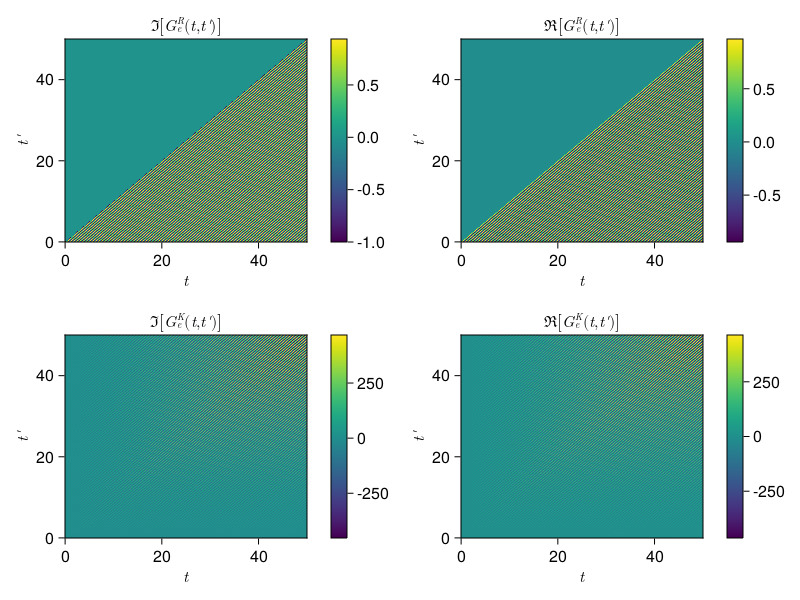

In [116]:
function plot_results_maps_electron(results)
    f = Figure()
    #retarded Green function
    f_ax = Axis(f[1, 1], title=L" \Im \left[ G^R_e(t,t')\right]", xlabel=L"t", ylabel=L"t'")
    G_R = (matrix(results[:G_R]) |> full)[1:2:end,1:2:end]
    ax = Junction.axis(p) |> collect
    im_G_R = imag.(G_R)
    hm = heatmap!(f_ax, ax, ax, im_G_R)
    Colorbar(f[1, 2], hm)
    f_ax = Axis(f[1, 3], title=L"\Re \left[ G^R_e(t,t')\right]", xlabel=L"t", ylabel=L"t'")
    re_G_R = real.(G_R)
    hm = heatmap!(f_ax, ax, ax, re_G_R)
    Colorbar(f[1, 4], hm)
    #Keldysh Green function
    f_ax = Axis(f[2, 1], title=L" \Im \left[ G^K_e(t,t')\right]", xlabel=L"t", ylabel=L"t'")
    G_K = (matrix(results[:G_K]) |> full)[1:2:end,1:2:end]
    ax = Junction.axis(p) |> collect
    im_G_K = imag.(G_K)
    hm = heatmap!(f_ax, ax, ax, im_G_K)
    Colorbar(f[2, 2], hm)
    f_ax = Axis(f[2, 3], title=L"\Re \left[ G^K_e(t,t')\right]", xlabel=L"t", ylabel=L"t'")
    re_G_K = real.(G_K)
    hm = heatmap!(f_ax, ax, ax, re_G_K)
    Colorbar(f[2, 4], hm)

    f
end
#We do not want to plot the full map for large simulation. 
#It would blow up the memory. 
if length(Junction.axis(p)) < 2001
    plot_results_maps_electron(results)
end

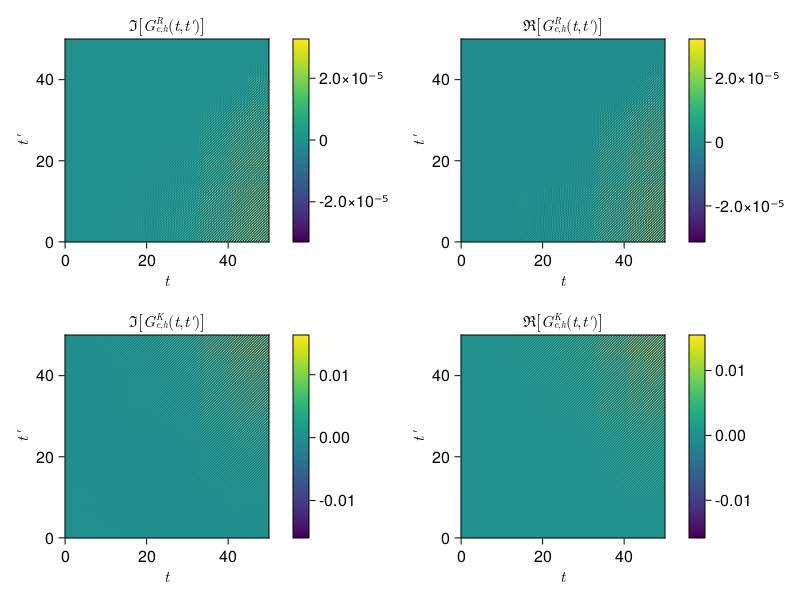

In [117]:
function plot_results_maps_electron(results)
    f = Figure()
    #retarded Green function
    f_ax = Axis(f[1, 1], title=L" \Im \left[ G^R_{e,h}(t,t')\right]", xlabel=L"t", ylabel=L"t'")
    G_R = (matrix(results[:G_R]) |> full)[2:2:end,1:2:end]
    ax = Junction.axis(p) |> collect
    im_G_R = imag.(G_R)
    hm = heatmap!(f_ax, ax, ax, im_G_R)
    Colorbar(f[1, 2], hm)
    f_ax = Axis(f[1, 3], title=L"\Re \left[ G^R_{e,h}(t,t')\right]", xlabel=L"t", ylabel=L"t'")
    re_G_R = real.(G_R)
    hm = heatmap!(f_ax, ax, ax, re_G_R)
    Colorbar(f[1, 4], hm)
    #Keldysh Green function
    f_ax = Axis(f[2, 1], title=L" \Im \left[ G^K_{e,h}(t,t')\right]", xlabel=L"t", ylabel=L"t'")
    G_K = (matrix(results[:G_K]) |> full)[2:2:end,1:2:end]
    ax = Junction.axis(p) |> collect
    im_G_K = imag.(G_K)
    hm = heatmap!(f_ax, ax, ax, im_G_K)
    Colorbar(f[2, 2], hm)
    f_ax = Axis(f[2, 3], title=L"\Re \left[ G^K_{e,h}(t,t')\right]", xlabel=L"t", ylabel=L"t'")
    re_G_K = real.(G_K)
    hm = heatmap!(f_ax, ax, ax, re_G_K)
    Colorbar(f[2, 4], hm)

    f
end
#We do not want to plot the full map for large simulation. 
#It would blow up the memory. 
if length(Junction.axis(p)) < 2001
    plot_results_maps_electron(results)
end

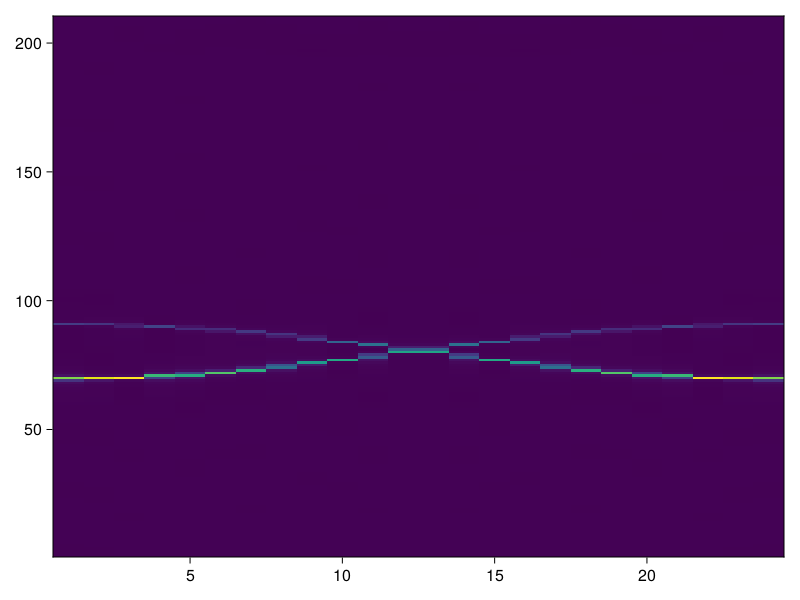

In [154]:
function density(ϕ)
    p = Junction.Parameters(δt=0.5, T=100, ϕl=t -> 0, ϕr=t -> ϕ, Δ = 1, Γl=1, Γr=1, β=1000, η = 0);
    results = Junction.compute_GR(p)
    mat = (results[:G_R] |> matrix)
    d = (mat[1:2:end,1] +  mat[2:2:end,2]) / (1im * pi)
    period = periodogram(d, fs = 1/p.δt)
end
function spectrum()
    results = density.(LinRange(0,2*π, 24 ))
    hcat([ r.power for r in results]...)
    return results.freq, hcat([ r.power for r in results]...)
end
spec =  spectrum()
heatmap(spec')

In [140]:
60/ (7/ 12)

102.85714285714285